# 1. Librerías


In [669]:
# Datos
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas de evaluación
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelos a Entrenar
import xgboost as xgb

# inhabilita warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Load Data

In [670]:
df = pd.read_csv('C:/Users/aalei/Desktop/GITHUB_DQ/clean_data.csv')
print('Rows: ', df.shape[0], '  Columns: ', df.shape[1])
df.head(2)

Rows:  12667   Columns:  8


,date,id,region,store,category,item,price,sales
0,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0
1,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0


In [671]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# 3. Feature Engineering

In [672]:
# Variables temporales
df['day'] = df['date'].dt.day
df['cumulative_month'] = (df['date'].dt.year - 2013) * 12 + df['date'].dt.month
df.head(2)

,date,id,region,store,category,item,price,sales,day,cumulative_month
0,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0,31,7
1,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0,31,8


In [673]:
# Revenue y lag_1 de revenue
df['revenue']= df['sales'] * df['price']
df['id_revenue_mean_lag_1'] = df.groupby(["id"])["revenue"].transform(lambda series: series.shift(2))

In [674]:
df1 = df[df['date'] < '2015-10-01'] # Quitar el mes de octubre que tiene algunos datos, pero es el mes que se busca predecir.

# Función para crear lags de variables agrupadas
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,resample_value):
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample(resample_value)[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
    gb_df_[f"{new_name}_lag_1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    gb_df_[f"{new_name}_lag_2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    gb_df_[f"{new_name}_lag_3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3)
    )
    gb_df_[f"{new_name}_lag_4"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(4)
    )

    print(f"Plus 3 lags features for: {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [675]:
# TARGET: SALES
print(f'Dimensión inicial df: {df.shape}')

# store/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

# region/store
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["region","store"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["region","store"], how = "left")

# store/category
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","category"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","category"], how = "left")

# category/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["category","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='2M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["category","item"], how = "left")

# region/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["region","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["region","item"], how = "left")

print(f'Dimensión final df: {df.shape}')
df.head()

Dimensión inicial df: (12667, 12)
Plus 3 lags features for: store_item_sales_sum
Plus 3 lags features for: region_store_sales_sum
Plus 3 lags features for: store_category_sales_sum
Plus 3 lags features for: category_item_sales_sum
Plus 3 lags features for: region_item_sales_sum
Dimensión final df: (12667, 32)


,date,id,region,store,category,item,price,sales,day,cumulative_month,...,store_category_sales_sum_lag_3,store_category_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4
0,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0,31,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0,31,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-09-30,12_11365,16,12,9,11365,2782.737200,24.0,30,9,...,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-31,12_11365,16,12,9,11365,1470.952381,13.0,31,13,...,32.0,6.0,0.0,40.0,20.0,NaN,40.0,20.0,NaN,NaN
4,2014-04-30,12_11365,16,12,9,11365,714.583333,10.0,30,16,...,92.0,32.0,NaN,NaN,NaN,NaN,13.0,40.0,20.0,NaN


In [676]:
# TARGET: REVENUE
print(f'Dimensión inicial df: {df.shape}')

# store/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","item"],
    target_column = "revenue",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

print(f'Dimensión final df: {df.shape}')
df.head()

Dimensión inicial df: (12667, 32)
Plus 3 lags features for: store_item_revenue_sum
Dimensión final df: (12667, 36)


,date,id,region,store,category,item,price,sales,day,cumulative_month,...,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4
0,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0,31,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0,31,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-09-30,12_11365,16,12,9,11365,2782.737200,24.0,30,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-31,12_11365,16,12,9,11365,1470.952381,13.0,31,13,...,20.0,NaN,40.0,20.0,NaN,NaN,115943.470578,34735.714286,NaN,NaN
4,2014-04-30,12_11365,16,12,9,11365,714.583333,10.0,30,16,...,NaN,NaN,13.0,40.0,20.0,NaN,19122.380952,115943.470578,34735.714286,NaN


In [677]:
# TARGET: PRICE
'''print(f'Dimensión inicial df: {df.shape}')

# store/item
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["store","item"],
    target_column = "price",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

# Promedio de ventas agrupadas por item y evento
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["id","item"],
    target_column = "price",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["id","item"], how = "left")

print(f'Dimensión final df: {df.shape}')
df.head()'''

'print(f\'Dimensión inicial df: {df.shape}\')\n\n# store/item\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = ["store","item"],\n    target_column = "price",\n    agg_func = np.mean,\n    agg_func_name =  "mean",\n    resample_value=\'3M\')\ndf = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")\n\n# Promedio de ventas agrupadas por item y evento\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = ["id","item"],\n    target_column = "price",\n    agg_func = np.mean,\n    agg_func_name = "mean",\n    resample_value=\'M\')\ndf = pd.merge(df, vars_ts_, on = ["date"] + ["id","item"], how = "left")\n\nprint(f\'Dimensión final df: {df.shape}\')\ndf.head()'

In [678]:
# Otras features para probar
# Price trend for the last six months 
# Last month shop revenue trend
# Months since the first sale for each shop/item pair and for item only

# Borrar features que no serán parte del modelo

In [680]:
COLUMNS_TO_DROP = ["revenue"] 
df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [681]:
print(df.columns)

Index(['date', 'id', 'region', 'store', 'category', 'item', 'price', 'sales',
       'day', 'cumulative_month', 'id_revenue_mean_lag_1',
       'store_item_sales_sum_lag_1', 'store_item_sales_sum_lag_2',
       'store_item_sales_sum_lag_3', 'store_item_sales_sum_lag_4',
       'region_store_sales_sum_lag_1', 'region_store_sales_sum_lag_2',
       'region_store_sales_sum_lag_3', 'region_store_sales_sum_lag_4',
       'store_category_sales_sum_lag_1', 'store_category_sales_sum_lag_2',
       'store_category_sales_sum_lag_3', 'store_category_sales_sum_lag_4',
       'category_item_sales_sum_lag_1', 'category_item_sales_sum_lag_2',
       'category_item_sales_sum_lag_3', 'category_item_sales_sum_lag_4',
       'region_item_sales_sum_lag_1', 'region_item_sales_sum_lag_2',
       'region_item_sales_sum_lag_3', 'region_item_sales_sum_lag_4',
       'store_item_revenue_sum_lag_1', 'store_item_revenue_sum_lag_2',
       'store_item_revenue_sum_lag_3', 'store_item_revenue_sum_lag_4'],
      dtyp

In [682]:
df.set_index("id", inplace = True)
df.sample(3)

,date,region,store,category,item,price,sales,day,cumulative_month,id_revenue_mean_lag_1,...,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4
id,,,,,,,,,,,,,,,,,,,,,
28_12134,2013-03-31,7,28,30,12134,299.0,8.0,31,3,1196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31_16169,2015-08-31,7,31,65,16169,299.0,6.0,31,32,1794.0,...,136.0,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35_2252,2014-10-31,8,35,30,2252,419.1,3.0,31,22,419.0,...,NaN,NaN,6.0,1.0,6.0,8.0,2513.5,599.0,3594.0,4761.8


# Train Test Split

In [683]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-06-30 00:00:00'), Timestamp('2015-07-31 00:00:00')]

Our validation index is [Timestamp('2015-08-31 00:00:00')]

Our test/prediction index is [Timestamp('2015-09-30 00:00:00')]



In [684]:
X_train = df[df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['sales']

X_valida = df[df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['sales']

X_test = df[df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['sales']

In [685]:
print(f'Train shape: {X_train.shape}, Valida shape: {X_valida.shape}, Test shape: {X_test.shape}')

Train shape: (11870, 32), Valida shape: (398, 32), Test shape: (399, 32)


In [686]:
X_train.head(2)

,region,store,category,item,price,day,cumulative_month,id_revenue_mean_lag_1,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,...,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4
id,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,1736.785714,31,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,3072.361111,31,8,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [687]:
X_test.head(2)

,region,store,category,item,price,day,cumulative_month,id_revenue_mean_lag_1,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,...,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4
id,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,995.680556,30,33,6835.0,13.0,6.0,...,31.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_12231,16,12,49,12231,350.000000,30,33,350.0,2.0,1.0,...,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [688]:
Y_test.sum()  # debe ser 0

1630.0

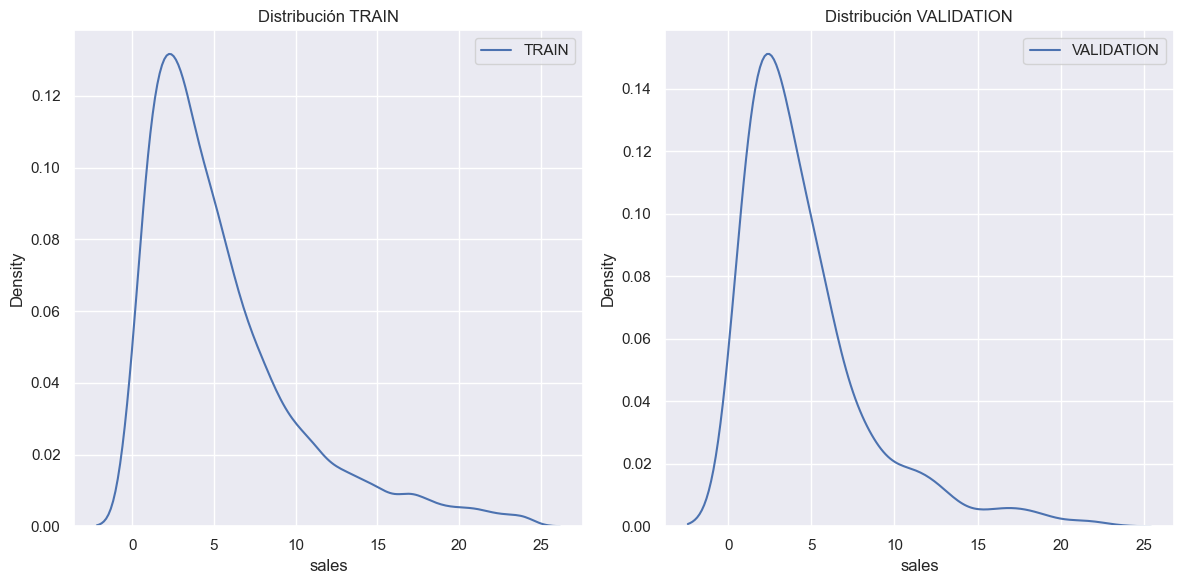

In [689]:
# Distribucion de target en train y validación
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.kdeplot(Y_train, ax=axes[0], label='TRAIN')
axes[0].set_title('Distribución TRAIN')
axes[0].legend()

sns.kdeplot(Y_valida, ax=axes[1], label='VALIDATION')
axes[1].set_title('Distribución VALIDATION')
axes[1].legend()

plt.tight_layout()
plt.show()


# Model Train

In [690]:
model = xgb.XGBRegressor(seed=175)

model.fit(
     X_train,
     Y_train,
     eval_metric = "rmse", 
     eval_set = [(X_train, Y_train), (X_valida, Y_valida)],  
     verbose = True,
     early_stopping_rounds = 15
     )

[0]	validation_0-rmse:4.18305	validation_1-rmse:3.41153
[1]	validation_0-rmse:3.87427	validation_1-rmse:3.13074
[2]	validation_0-rmse:3.66576	validation_1-rmse:3.02805
[3]	validation_0-rmse:3.52649	validation_1-rmse:2.89510
[4]	validation_0-rmse:3.42989	validation_1-rmse:2.84422
[5]	validation_0-rmse:3.36076	validation_1-rmse:2.85322
[6]	validation_0-rmse:3.29321	validation_1-rmse:2.82885
[7]	validation_0-rmse:3.21814	validation_1-rmse:2.80583
[8]	validation_0-rmse:3.18422	validation_1-rmse:2.80727
[9]	validation_0-rmse:3.13731	validation_1-rmse:2.79814
[10]	validation_0-rmse:3.09781	validation_1-rmse:2.76651
[11]	validation_0-rmse:3.06041	validation_1-rmse:2.76578
[12]	validation_0-rmse:3.03993	validation_1-rmse:2.76035
[13]	validation_0-rmse:3.02288	validation_1-rmse:2.75273
[14]	validation_0-rmse:2.98741	validation_1-rmse:2.75806
[15]	validation_0-rmse:2.95497	validation_1-rmse:2.73597
[16]	validation_0-rmse:2.93451	validation_1-rmse:2.73641
[17]	validation_0-rmse:2.91932	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Features Importance

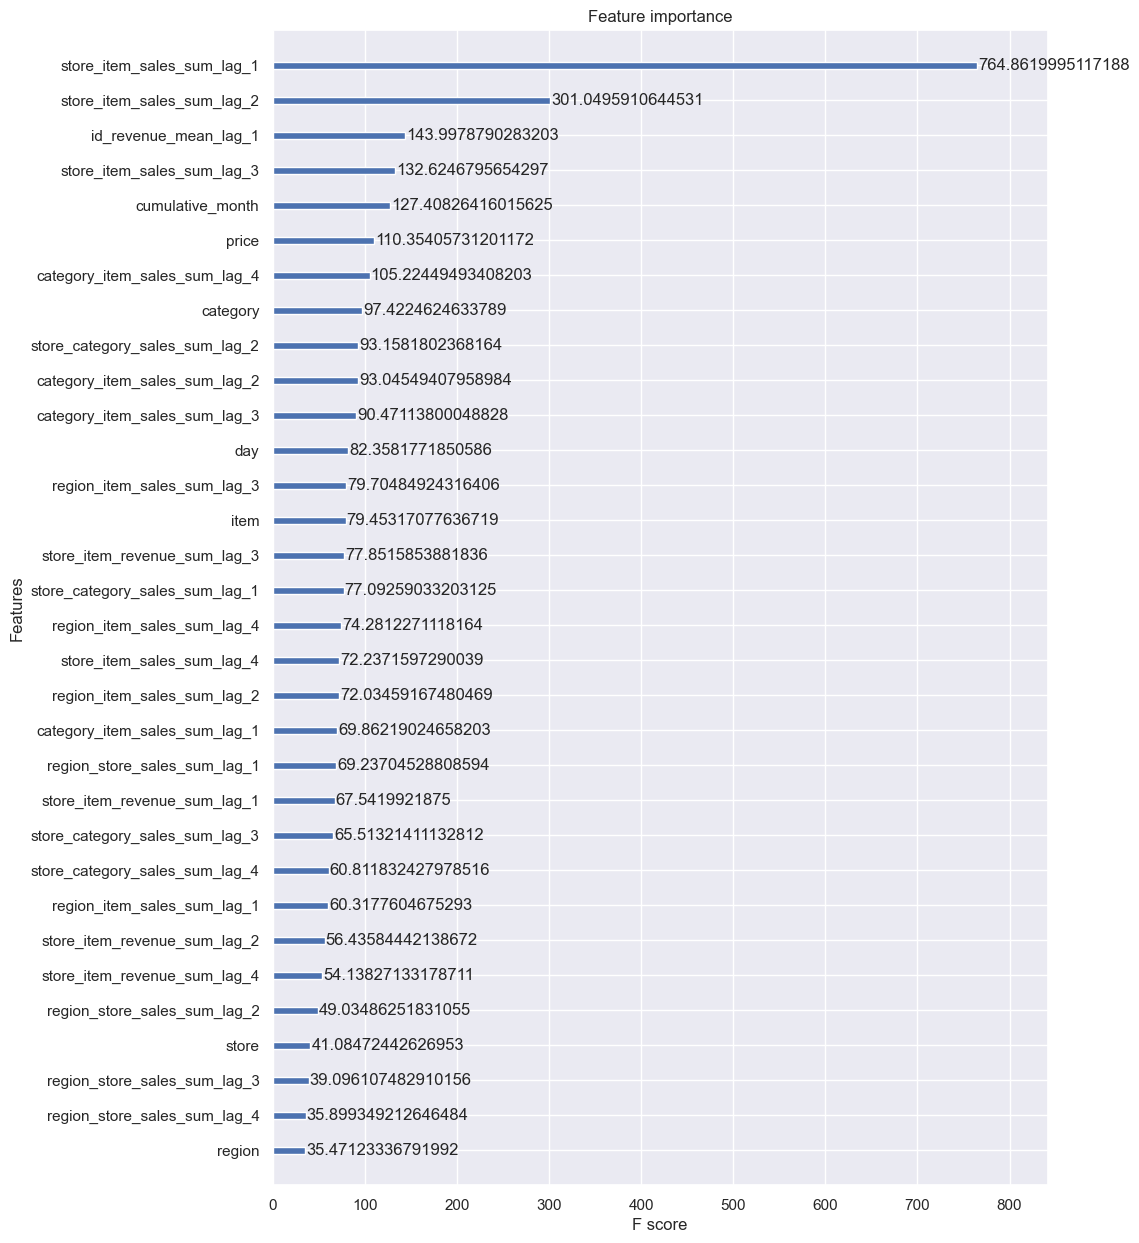

In [691]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

# Model Predict

In [692]:

Y_train_predict = model.predict(X_train).clip(0,30)
Y_valida_predict = model.predict(X_valida).clip(0,30)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_661
Validation RMSE: 2_726


# Model Evaluations

### Evaluación del Error

RMSE: 2.7257
MAE: 1.9456
R2-Score: 48.12%


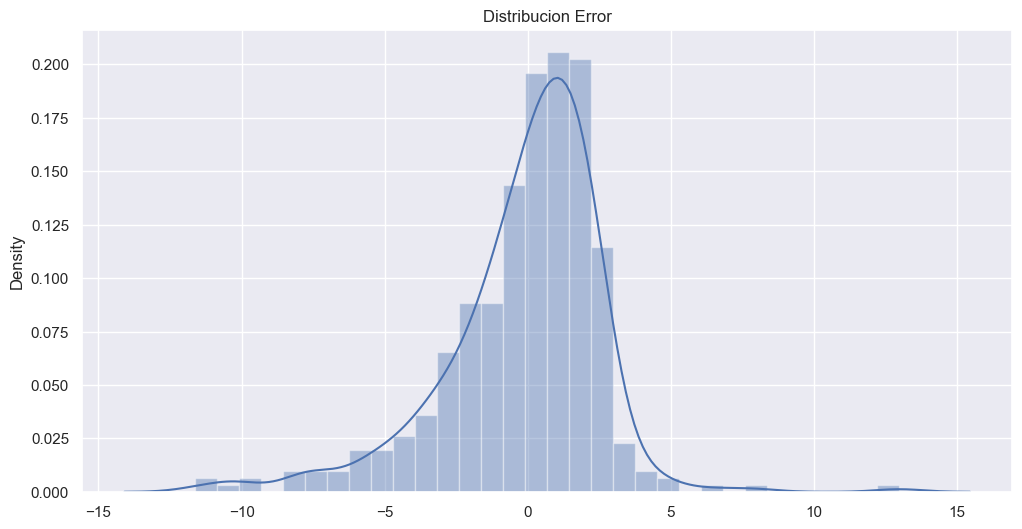

In [693]:
error = Y_valida_predict - Y_valida.values

mae = np.mean(np.abs(error))
mse = np.mean(error**2)
rmse = np.sqrt(np.mean(error**2))

print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('R2-Score: {:.2%}'.format(r2_score(Y_valida, Y_valida_predict)))

sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(error).set_title('Distribucion Error')
plt.show()

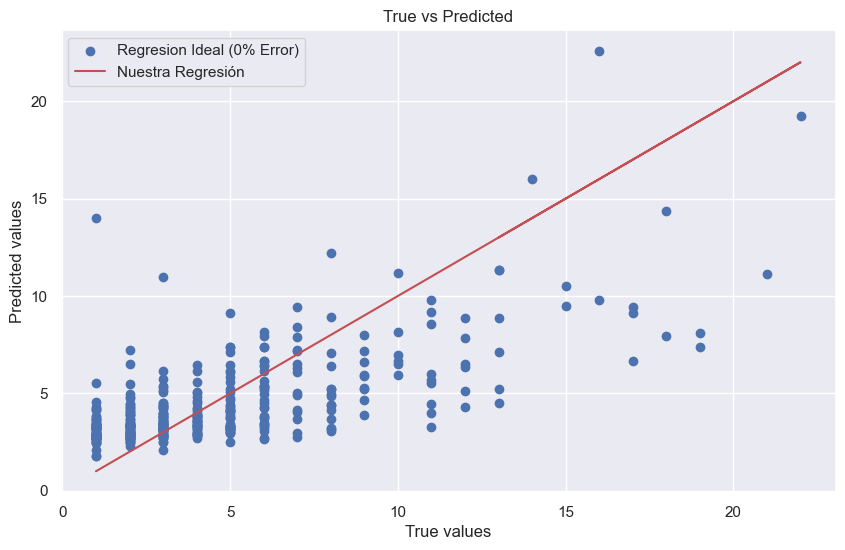

In [694]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(Y_valida, Y_valida_predict)
plt.plot(Y_valida, Y_valida,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

### Intervalo de confianza del Error

In [695]:
confidence=95
z = (100-confidence)/2
print("Intervalo del error (confianza",confidence,"%):",round(np.percentile(error, 100-z),1),"/",round(np.percentile(error, z),1))

Intervalo del error (confianza 95 %): 3.3 / -7.6


### Predición en datos de validacion

In [696]:
# Agregar la predicción como una nueva columna al DataFrame X_valida
X_valida.reset_index(inplace = True)
X_valida.head(2)
X_valida['sales_predict'] = Y_valida_predict

In [697]:
X_valida.head()

,id,region,store,category,item,price,day,cumulative_month,id_revenue_mean_lag_1,store_item_sales_sum_lag_1,...,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4,sales_predict
0,12_11365,16,12,9,11365,1870.214286,31,32,11390.958333,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.205296
1,12_11369,16,12,9,11369,1041.966667,31,32,17798.772727,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.126120
2,12_12231,16,12,49,12231,350.000000,31,32,1400.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.001244
3,12_482,16,12,73,482,3300.000000,31,32,33000.000000,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.396260
4,12_839,16,12,73,839,3300.000000,31,32,6600.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.881143


# Test Prediction

In [698]:
# Eliminar la columna 'sales' si está presente
if "sales" in X_test.columns:
    X_test.drop("sales", axis=1, inplace=True)

# Realizar la predicción
Y_test_predict = model.predict(X_test).clip(0,30)

# Agregar la predicción como una nueva columna al DataFrame X_test
X_test.reset_index(inplace = True)
X_test['sales'] = Y_test_predict
X_test.head(2)

,id,region,store,category,item,price,day,cumulative_month,id_revenue_mean_lag_1,store_item_sales_sum_lag_1,...,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4,sales
0,12_11365,16,12,9,11365,995.680556,30,33,6835.0,13.0,...,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.411191
1,12_12231,16,12,49,12231,350.000000,30,33,350.0,2.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.085222


In [699]:
X_test.shape

(399, 34)